In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pmf import pmf

Load dataset

In [2]:
anime_df = pd.read_csv('data/anime.csv')
anime_df = anime_df.rename(columns={'rating': 'avg_rating'})
rating_df = pd.read_csv('data/rating.csv')

Sample a few data points to make it easier for computation

In [3]:
rating_df = rating_df.sample(n=100_000, random_state=42)

In [4]:
rating_df = rating_df[rating_df['rating'] != -1]
rating_df['rating'] = (rating_df['rating'] - 1) / 9.0 # Normalize ratings to [0, 1]
combined_df = pd.merge(anime_df, rating_df, on='anime_id', how='inner')

uniq_users = combined_df['user_id'].unique()
uniq_animes = combined_df['anime_id'].unique()

n_users = len(uniq_users)
n_animes = len(uniq_animes)

df_copy = combined_df.copy()
train_set = df_copy.sample(frac=0.75, random_state=0)
test_set = df_copy.drop(train_set.index)

In [5]:
pmf_model = pmf(n_users=n_users, n_animes=n_animes, lambda_U=0.3, lambda_V=0.3, uniq_users=uniq_users, uniq_animes=uniq_animes, n_dimesions=15)

In [9]:
log_ps, rmse_train, rmse_test = pmf_model.train(train_set=train_set, test_set=test_set,n_epochs=150)

Log p a-posteriori at iteration 10 : -116199.09109393742 , RMSE train: 0.7045473528018416 , RMSE test: 3.658692093943665 , Train loss: 0.005526049661236987
Log p a-posteriori at iteration 20 : -116194.98054648013 , RMSE train: 0.7069863265162889 , RMSE test: 3.5955752045431764 , Train loss: 0.005531934985494615
Log p a-posteriori at iteration 30 : -116192.89163884535 , RMSE train: 0.7086408436597592 , RMSE test: 3.561051520366418 , Train loss: 0.005536142208193331
Log p a-posteriori at iteration 40 : -116191.63584165447 , RMSE train: 0.7092980660264806 , RMSE test: 3.543238719636301 , Train loss: 0.005539139798673679
Log p a-posteriori at iteration 50 : -116190.81326902928 , RMSE train: 0.7097297663358029 , RMSE test: 3.5321097419962904 , Train loss: 0.005541161612575358
Log p a-posteriori at iteration 60 : -116190.2423571049 , RMSE train: 0.7103044334778381 , RMSE test: 3.5206682745503746 , Train loss: 0.005542444934005868
Log p a-posteriori at iteration 70 : -116189.82856978652 , RMS

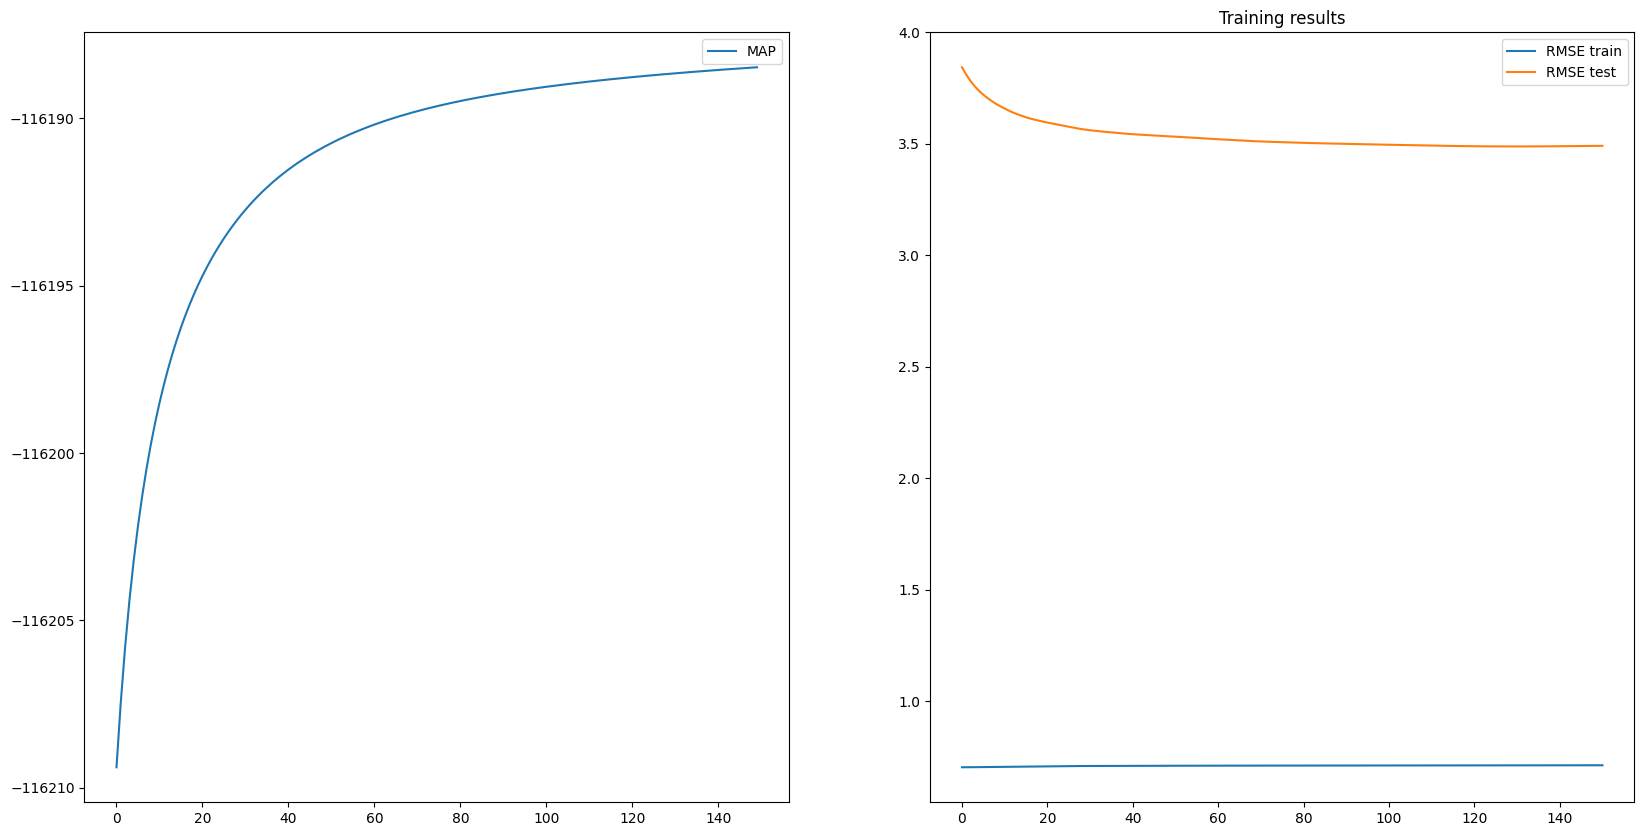

In [10]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

In [11]:
print('RMSE of training set:', pmf_model.evaluate(train_set))
print('RMSE of testing set:', pmf_model.evaluate(test_set))

RMSE of training set: 0.7118837048951375
RMSE of testing set: 3.4910740539871665
